In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contextily as cx
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap

In [2]:
data_path = r"F:/IRS_Migration/"
SHELDUS = pd.read_csv("F:/SHELDUS/ORIGINAL.csv")
state    = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/usstate/cb_2018_us_state_500k.shp").to_crs('ESRI:102003')
county  = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/maincounty/us_conu_county.shp").to_crs('ESRI:102003')
df_pep_2010 = pd.read_csv(r"F:\PEP\co-est2010-alldata.csv", encoding='latin-1')
df_pep_2020 = pd.read_csv(r"F:\PEP\co-est2020-alldata.csv", encoding='latin-1')
SVI_10 = pd.read_csv(r"F:\PEP\SVI_2010_US_county.csv")
house_price = pd.read_csv(r"F:\LongMigration\Data\Zillow\County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
SVI_10['FIPS'] = SVI_10['FIPS'].astype("str").str.rjust(5,"0")

state = state[~state["NAME"].isin(["Alaska","Hawaii","Puerto Rico",
                                   "American Samoa","United States Virgin Islands",
                                   "Guam","Commonwealth of the Northern Mariana Islands"])]

In [3]:
SHELDUS['County FIPS'] = SHELDUS['County FIPS'].str.replace("'", "")
SHELDUS_0020 = SHELDUS[(SHELDUS["Year"]<2021) & (SHELDUS["Year"]>2000)]

In [4]:
SHELDUS_0020 = SHELDUS_0020[~((SHELDUS_0020['Year'] == 2000) & (SHELDUS_0020['Month'] <= 6))]
SHELDUS_0020 = SHELDUS_0020[~((SHELDUS_0020['Year'] == 2020) & (SHELDUS_0020['Month'] >= 7))]

In [5]:
SHELDUS_0020_sel = SHELDUS_0020[SHELDUS_0020["Hazard"].isin(['Flooding','Hurricane/Tropical Storm','Wildfire'])].reset_index(drop=True)

In [6]:
SHELDUS_0020_hurricane = SHELDUS_0020_sel[SHELDUS_0020_sel["Hazard"]=="Hurricane/Tropical Storm"].reset_index()
SHELDUS_0020_flooding  = SHELDUS_0020_sel[SHELDUS_0020_sel["Hazard"]=="Flooding"].reset_index()

In [7]:
hurricane_induced_floods = pd.merge(
    SHELDUS_0020_flooding, 
    SHELDUS_0020_hurricane, 
    on=['County FIPS', 'Year', 'Month'],
    suffixes=('_flood', '_hurricane')
)
flood_indices = hurricane_induced_floods['index_flood']

In [8]:
SHELDUS_0020_sel.loc[flood_indices, 'Hazard'] = 'Hurricane/Tropical Storm'

In [9]:
SHELDUS_0020_use = SHELDUS_0020_sel[(SHELDUS_0020_sel["Fatalities"]!=0)|(SHELDUS_0020_sel["Injuries"]!=0)|(SHELDUS_0020_sel["PropertyDmgPerCapita(ADJ 2020)"]>1)]
SHELDUS_0020_use_group = SHELDUS_0020_use.groupby(["County FIPS","Hazard","Year"]).agg({"Month":"count",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()
SHELDUS_0020_use_group = SHELDUS_0020_use_group.rename(columns={"Month":"count"})
df_20_years_by_county = SHELDUS_0020_use_group.groupby(['County FIPS',"Hazard"]).agg({"count":"sum",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()


In [10]:
SHELDUS_20_use_flooding  = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Flooding"]
SHELDUS_20_use_hurricane = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Hurricane/Tropical Storm"]
SHELDUS_20_use_wildfire  = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Wildfire"]

In [11]:
def classify_impact(data, value_column):
    Q1 = data[value_column].quantile(0.25)
    Q3 = data[value_column].quantile(0.75)
    
    def classification(value):
        if value <= Q1:
            return 'Low Impact'
        elif (value > Q1) & (value < Q3):
            return 'Moderate Impact'
        elif value >= Q3:
            return 'High Impact'
    
    return data[value_column].apply(classification)

In [12]:
Q1_20_flooding = SHELDUS_20_use_flooding["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.25)
Q3_20_flooding = SHELDUS_20_use_flooding["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.75)

Q1_20_hurricane = SHELDUS_20_use_hurricane["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.25)
Q3_20_hurricane = SHELDUS_20_use_hurricane["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.75)

Q1_20_wildfire = SHELDUS_20_use_wildfire["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.25)
Q3_20_wildfire = SHELDUS_20_use_wildfire["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.75)

In [13]:
SHELDUS_20_use_flooding['ImpactLevel'] = classify_impact(SHELDUS_20_use_flooding, "PropertyDmgPerCapita(ADJ 2020)")
SHELDUS_20_use_hurricane['ImpactLevel'] = classify_impact(SHELDUS_20_use_hurricane, "PropertyDmgPerCapita(ADJ 2020)")
SHELDUS_20_use_wildfire['ImpactLevel'] = classify_impact(SHELDUS_20_use_wildfire, "PropertyDmgPerCapita(ADJ 2020)")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_33016\2968689653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHELDUS_20_use_flooding['ImpactLevel'] = classify_impact(SHELDUS_20_use_flooding, "PropertyDmgPerCapita(ADJ 2020)")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_33016\2968689653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHELDUS_20_use_hurricane['ImpactLevel'] = classify_impact(SHELDUS_20_use_hurricane, "PropertyDmgPerCapita(ADJ 2020)")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_33

In [14]:
SHELDUS_flooding_county  = list(SHELDUS_20_use_flooding["County FIPS"].unique())
SHELDUS_hurricane_county = list(SHELDUS_20_use_hurricane["County FIPS"].unique())
SHELDUS_wildfire_county  = list(SHELDUS_20_use_wildfire["County FIPS"].unique())

flooding_county  = county[county["FIPS"].isin(SHELDUS_flooding_county)].reset_index(drop=True)
hurricane_county = county[county["FIPS"].isin(SHELDUS_hurricane_county)].reset_index(drop=True)
wildfire_county  = county[county["FIPS"].isin(SHELDUS_wildfire_county)].reset_index(drop=True)

In [15]:
df_SHELDUS_20_flooding_county  = pd.merge(SHELDUS_20_use_flooding,flooding_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_20_hurricane_county = pd.merge(SHELDUS_20_use_hurricane,hurricane_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_20_wildfire_county  = pd.merge(SHELDUS_20_use_wildfire,wildfire_county,left_on="County FIPS",right_on="FIPS")

gdf_SHELDUS_20_flooding_county = gpd.GeoDataFrame(df_SHELDUS_20_flooding_county,geometry="geometry")
gdf_SHELDUS_20_hurricane_county= gpd.GeoDataFrame(df_SHELDUS_20_hurricane_county,geometry="geometry")
gdf_SHELDUS_20_wildfire_county = gpd.GeoDataFrame(df_SHELDUS_20_wildfire_county,geometry="geometry")

In [16]:
SHELDUS_20_use_hurricane

,County FIPS,Hazard,count,Fatalities,Injuries,PropertyDmg(ADJ 2020),PropertyDmgPerCapita(ADJ 2020),ImpactLevel
1,01001,Hurricane/Tropical Storm,2,0.00,0.0,348956.00,3.644830,Low Impact
3,01003,Hurricane/Tropical Storm,4,0.00,0.0,14903583.36,18.590288,Moderate Impact
5,01005,Hurricane/Tropical Storm,2,0.00,0.0,103344.66,1.754460,Low Impact
7,01007,Hurricane/Tropical Storm,2,0.00,0.0,348956.00,8.162715,Moderate Impact
9,01009,Hurricane/Tropical Storm,1,0.00,0.0,80528.31,1.463220,Low Impact
...,...,...,...,...,...,...,...,...
4231,72133,Hurricane/Tropical Storm,1,0.00,0.0,493355.24,22.601940,Moderate Impact
4241,72149,Hurricane/Tropical Storm,3,0.00,0.1,9780611.92,120.887850,Moderate Impact
4243,72151,Hurricane/Tropical Storm,2,0.17,0.0,740032.86,9.460915,Moderate Impact
4246,72153,Hurricane/Tropical Storm,1,0.00,0.0,493355.24,10.741690,Moderate Impact


In [17]:
df_pep_2010["state"] = df_pep_2010["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2010["county"] = df_pep_2010["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2010["FIPS"] = df_pep_2010["state"] + df_pep_2010["county"]

df_pep_2020["state"] = df_pep_2020["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2020["county"] = df_pep_2020["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2020["FIPS"] = df_pep_2020["state"] + df_pep_2020["county"]

In [18]:
df_pep_0120 = pd.merge(df_pep_2010,df_pep_2020,on="FIPS")

In [19]:
correct_netmig_columns = []
for year in range(2001, 2021):
    column_name_x = f'RNETMIG{year}_x'
    column_name_y = f'RNETMIG{year}_y'
    column_name = f'RNETMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_y)

In [20]:
correct_netmig_columns1 = []
for year in range(2001, 2021):
    column_name_x = f'RDOMESTICMIG{year}_x'
    column_name_y = f'RDOMESTICMIG{year}_y'
    column_name = f'RDOMESTICMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name_y)

In [21]:
correct_netmig_columns2 = []
for year in range(2001, 2021):
    column_name_x = f'RINTERNATIONALMIG{year}_x'
    column_name_y = f'RINTERNATIONALMIG{year}_y'
    column_name = f'RINTERNATIONALMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name_y)

In [22]:
df_pep_0120["NetMigrationRateTotal"] = df_pep_0120[correct_netmig_columns].mean(axis=1)
df_pep_0120["NetMigrationRateDome"]  = df_pep_0120[correct_netmig_columns1].mean(axis=1)
df_pep_0120["NetMigrationRateInter"] = df_pep_0120[correct_netmig_columns2].mean(axis=1)
df_pep_0120_used = df_pep_0120[['FIPS','STNAME_x', 'CTYNAME_x', 'NetMigrationRateTotal', 'NetMigrationRateDome', 'NetMigrationRateInter']]

In [23]:
df_pep_0120_used

,FIPS,STNAME_x,CTYNAME_x,NetMigrationRateTotal,NetMigrationRateDome,NetMigrationRateInter
0,01000,Alabama,Alabama,2.276452,1.274938,1.001513
1,01001,Alabama,Autauga County,5.813354,5.764054,0.049301
2,01003,Alabama,Baldwin County,22.393108,21.326295,1.066813
3,01005,Alabama,Barbour County,-7.284080,-8.311879,1.027799
4,01007,Alabama,Bibb County,1.336304,0.909290,0.427014
...,...,...,...,...,...,...
3185,56037,Wyoming,Sweetwater County,-5.170849,-5.811242,0.640394
3186,56039,Wyoming,Teton County,3.381039,-0.109523,3.490563
3187,56041,Wyoming,Uinta County,-6.927289,-7.187357,0.260068
3188,56043,Wyoming,Washakie County,-7.130189,-7.194011,0.063821


In [24]:
df_NMR = pd.merge(df_pep_0120_used,county,on="FIPS",how="inner")
gdf_NMR = gpd.GeoDataFrame(df_NMR,geometry="geometry")

Text(0.5, 1.0, 'Net International Migration Rate from 2000-2020 (Calculated by Average Migration Rate)')

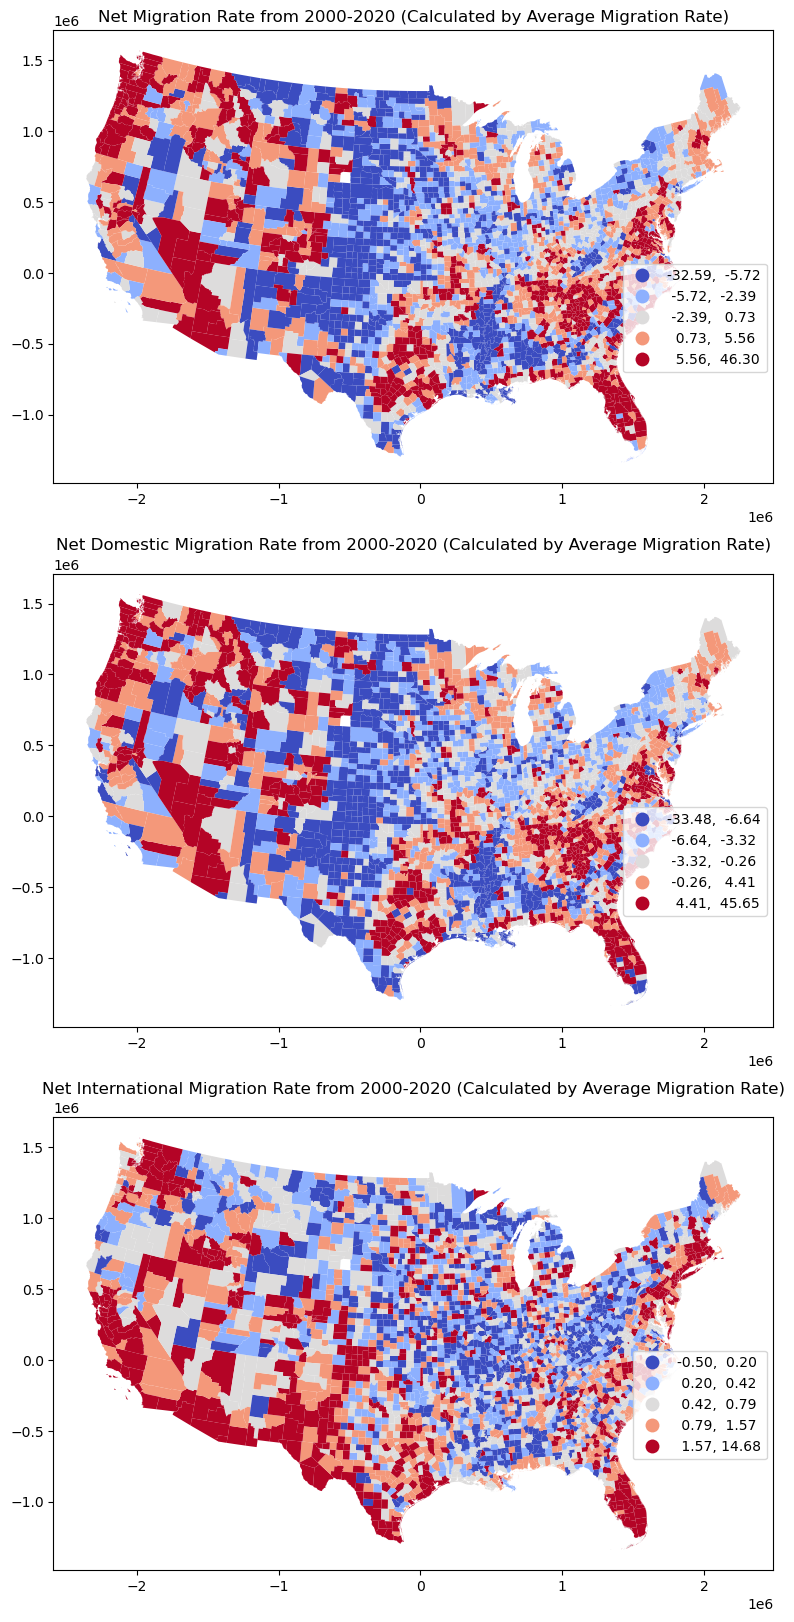

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(16, 20))
gdf_NMR.plot(column="NetMigrationRateTotal",cmap="coolwarm",
             scheme="quantiles",
#              scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[0])
leg = axes[0].get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
axes[0].set_title("Net Migration Rate from 2000-2020 (Calculated by Average Migration Rate)")

gdf_NMR.plot(column="NetMigrationRateDome",cmap="coolwarm",
             scheme="quantiles",
#              scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[1])
leg = axes[1].get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
axes[1].set_title("Net Domestic Migration Rate from 2000-2020 (Calculated by Average Migration Rate)")

gdf_NMR.plot(column="NetMigrationRateInter",cmap="coolwarm",
             scheme="quantiles",
#              scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[2])
leg = axes[2].get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
axes[2].set_title("Net International Migration Rate from 2000-2020 (Calculated by Average Migration Rate)")

In [26]:
used_list = ["E_P_POV","E_P_UNEMP","E_P_PCI","E_P_NOHSDIP","P_AGE65","P_AGE17","P_SNGPRNT","P_MINORITY","E_P_LIMENG","E_P_MUNIT","E_P_MOBILE","E_P_CROWD","E_P_NOVEH","P_GROUPQ"]
name_list = ["%BelowPoverty","%Unemployed","PerCapitaIncome","%NoHighSchoolDiploma25+","%Age65+","%Age18-","%Single-parent household","%Minority","%Age5+LessThanWellEnglish","%Multi-Unit House","%MobileHome","%HousePop>Room","%NoVehicleHousehold","%GroupQuarters"]
theme1_list = ["%BelowPoverty","%Unemployed","PerCapitaIncome","%NoHighSchoolDiploma25+"]
theme2_list = ["%Age65+","%Age18-","%Single-parent household"]
theme3_list = ["%Minority","%Age5+LessThanWellEnglish"]
theme4_list = ["%Multi-Unit House","%MobileHome","%HousePop>Room","%NoVehicleHousehold","%GroupQuarters"]
disaster_list = ["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]
columns_to_normalize_all = ["%BelowPoverty","%Unemployed","PerCapitaIncome","%NoHighSchoolDiploma25+","%Age65+","%Age18-","%Single-parent household","%Minority","%Age5+LessThanWellEnglish","%Multi-Unit House","%MobileHome","%HousePop>Room","%NoVehicleHousehold","%GroupQuarters","count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]

In [27]:
SVI_10[name_list] = SVI_10[used_list]
gdf_NMR_mig = gdf_NMR[["FIPS","NetMigrationRateTotal","NetMigrationRateDome","NetMigrationRateInter"]]
SVI_10_merge = pd.merge(SVI_10,gdf_NMR_mig,on="FIPS")

In [28]:
hurricane_SVI = SVI_10_merge[SVI_10_merge["FIPS"].isin(SHELDUS_hurricane_county)].reset_index()
hurricane_SVI = pd.merge(hurricane_SVI,SHELDUS_20_use_hurricane,left_on="FIPS",right_on="County FIPS")

In [29]:
hurricane_SVI[columns_to_normalize_all] = (hurricane_SVI[columns_to_normalize_all] - hurricane_SVI[columns_to_normalize_all].mean()) / hurricane_SVI[columns_to_normalize_all].std()

In [30]:
# hurricane_SVI.to_csv(r"F:\LongMigration\Data\hurricane_svi.csv")

In [31]:
results_hurricane_domes = {}
results_hurricane_inter = {}

In [32]:
X4 = sm.add_constant(hurricane_SVI[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(hurricane_SVI['NetMigrationRateDome'], X4).fit()
results_hurricane_domes['Model 4'] = model4.summary()

X5 = sm.add_constant(hurricane_SVI[disaster_list])
model5 = sm.OLS(hurricane_SVI['NetMigrationRateDome'], X5).fit()
results_hurricane_domes['Model 5'] = model5.summary()

X6 = sm.add_constant(hurricane_SVI[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(hurricane_SVI['NetMigrationRateDome'], X6).fit()
results_hurricane_domes['Model 6'] = model6.summary()


In [33]:
results_hurricane_domes

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     NetMigrationRateDome   R-squared:                       0.456
 Model:                              OLS   Adj. R-squared:                  0.445
 Method:                   Least Squares   F-statistic:                     42.22
 Date:                  Tue, 29 Oct 2024   Prob (F-statistic):           1.46e-83
 Time:                          22:37:32   Log-Likelihood:                -2460.3
 No. Observations:                   721   AIC:                             4951.
 Df Residuals:                       706   BIC:                             5019.
 Df Model:                            14                                         
 Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------

In [34]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [35]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.455714,0.444921
Disaster,0.026165,0.020724
Total,0.472888,0.459372


In [36]:
X4 = sm.add_constant(hurricane_SVI[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(hurricane_SVI['NetMigrationRateInter'], X4).fit()
results_hurricane_inter['Model 4'] = model4.summary()

X5 = sm.add_constant(hurricane_SVI[disaster_list])
model5 = sm.OLS(hurricane_SVI['NetMigrationRateInter'], X5).fit()
results_hurricane_inter['Model 5'] = model5.summary()

X6 = sm.add_constant(hurricane_SVI[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(hurricane_SVI['NetMigrationRateInter'], X6).fit()
results_hurricane_inter['Model 6'] = model6.summary()

In [37]:
results_hurricane_inter

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                             
 Dep. Variable:     NetMigrationRateInter   R-squared:                       0.723
 Model:                               OLS   Adj. R-squared:                  0.717
 Method:                    Least Squares   F-statistic:                     131.6
 Date:                   Tue, 29 Oct 2024   Prob (F-statistic):          7.30e-186
 Time:                           22:37:32   Log-Likelihood:                -962.23
 No. Observations:                    721   AIC:                             1954.
 Df Residuals:                        706   BIC:                             2023.
 Df Model:                             14                                         
 Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -------------

In [38]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [39]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.722900,0.717405
Disaster,0.007781,0.002238
Total,0.727093,0.720096


In [40]:
hurricane_SVI_high = hurricane_SVI[hurricane_SVI["ImpactLevel"]=="High Impact"]

In [41]:
results_hurricane_high_domes = {}
results_hurricane_high_inter = {}

In [42]:
X4 = sm.add_constant(hurricane_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(hurricane_SVI_high['NetMigrationRateDome'], X4).fit()
results_hurricane_high_domes['Model 4'] = model4.summary()

X5 = sm.add_constant(hurricane_SVI_high[disaster_list])
model5 = sm.OLS(hurricane_SVI_high['NetMigrationRateDome'], X5).fit()
results_hurricane_high_domes['Model 5'] = model5.summary()

X6 = sm.add_constant(hurricane_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(hurricane_SVI_high['NetMigrationRateDome'], X6).fit()
results_hurricane_high_domes['Model 6'] = model6.summary()

In [43]:
results_hurricane_high_domes

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     NetMigrationRateDome   R-squared:                       0.495
 Model:                              OLS   Adj. R-squared:                  0.452
 Method:                   Least Squares   F-statistic:                     11.61
 Date:                  Tue, 29 Oct 2024   Prob (F-statistic):           2.30e-18
 Time:                          22:37:32   Log-Likelihood:                -618.82
 No. Observations:                   181   AIC:                             1268.
 Df Residuals:                       166   BIC:                             1316.
 Df Model:                            14                                         
 Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------

In [44]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [45]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.494641,0.452020
Disaster,0.102444,0.082045
Total,0.539570,0.488411


In [46]:
X4 = sm.add_constant(hurricane_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(hurricane_SVI_high['NetMigrationRateInter'], X4).fit()
results_hurricane_high_inter['Model 4'] = model4.summary()

X5 = sm.add_constant(hurricane_SVI_high[disaster_list])
model5 = sm.OLS(hurricane_SVI_high['NetMigrationRateInter'], X5).fit()
results_hurricane_high_inter['Model 5'] = model5.summary()

X6 = sm.add_constant(hurricane_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(hurricane_SVI_high['NetMigrationRateInter'], X6).fit()
results_hurricane_high_inter['Model 6'] = model6.summary()

In [47]:
results_hurricane_high_inter

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                             
 Dep. Variable:     NetMigrationRateInter   R-squared:                       0.651
 Model:                               OLS   Adj. R-squared:                  0.622
 Method:                    Least Squares   F-statistic:                     22.15
 Date:                   Tue, 29 Oct 2024   Prob (F-statistic):           4.83e-31
 Time:                           22:37:32   Log-Likelihood:                -235.65
 No. Observations:                    181   AIC:                             501.3
 Df Residuals:                        166   BIC:                             549.3
 Df Model:                             14                                         
 Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -------------

In [48]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [49]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.651338,0.621933
Disaster,0.041471,0.019686
Total,0.658545,0.620606


In [50]:
flooding_SVI = SVI_10_merge[SVI_10_merge["FIPS"].isin(SHELDUS_flooding_county)].reset_index()
flooding_SVI = pd.merge(flooding_SVI,SHELDUS_20_use_flooding,left_on="FIPS",right_on="County FIPS")

In [51]:
flooding_SVI[columns_to_normalize_all] = (flooding_SVI[columns_to_normalize_all] - flooding_SVI[columns_to_normalize_all].mean()) / flooding_SVI[columns_to_normalize_all].std()

In [52]:
results_flooding_domes = {}
results_flooding_inter = {}

In [53]:
X4 = sm.add_constant(flooding_SVI[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(flooding_SVI['NetMigrationRateDome'], X4).fit()
results_flooding_domes['Model 4'] = model4.summary()

X5 = sm.add_constant(flooding_SVI[disaster_list])
model5 = sm.OLS(flooding_SVI['NetMigrationRateDome'], X5).fit()
results_flooding_domes['Model 5'] = model5.summary()

X6 = sm.add_constant(flooding_SVI[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(flooding_SVI['NetMigrationRateDome'], X6).fit()
results_flooding_domes['Model 6'] = model6.summary()

In [54]:
results_flooding_domes

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     NetMigrationRateDome   R-squared:                       0.263
 Model:                              OLS   Adj. R-squared:                  0.259
 Method:                   Least Squares   F-statistic:                     70.21
 Date:                  Tue, 29 Oct 2024   Prob (F-statistic):          8.84e-171
 Time:                          22:37:32   Log-Likelihood:                -9307.4
 No. Observations:                  2774   AIC:                         1.864e+04
 Df Residuals:                      2759   BIC:                         1.873e+04
 Df Model:                            14                                         
 Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------

In [55]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [56]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.262673,0.258932
Disaster,0.022238,0.020826
Total,0.279440,0.274733


In [57]:
X4 = sm.add_constant(flooding_SVI[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(flooding_SVI['NetMigrationRateInter'], X4).fit()
results_flooding_inter['Model 4'] = model4.summary()

X5 = sm.add_constant(flooding_SVI[disaster_list])
model5 = sm.OLS(flooding_SVI['NetMigrationRateInter'], X5).fit()
results_flooding_inter['Model 5'] = model5.summary()

X6 = sm.add_constant(flooding_SVI[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(flooding_SVI['NetMigrationRateInter'], X6).fit()
results_flooding_inter['Model 6'] = model6.summary()

In [58]:
results_flooding_inter

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                             
 Dep. Variable:     NetMigrationRateInter   R-squared:                       0.645
 Model:                               OLS   Adj. R-squared:                  0.643
 Method:                    Least Squares   F-statistic:                     358.5
 Date:                   Tue, 29 Oct 2024   Prob (F-statistic):               0.00
 Time:                           22:37:32   Log-Likelihood:                -3311.1
 No. Observations:                   2774   AIC:                             6652.
 Df Residuals:                       2759   BIC:                             6741.
 Df Model:                             14                                         
 Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -------------

In [59]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [60]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.645280,0.643480
Disaster,0.033039,0.031642
Total,0.645999,0.643686


In [61]:
flooding_SVI_high = flooding_SVI[flooding_SVI["ImpactLevel"]=="High Impact"]

In [62]:
results_flooding_high_domes = {}
results_flooding_high_inter = {}

In [63]:
X4 = sm.add_constant(flooding_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(flooding_SVI_high['NetMigrationRateDome'], X4).fit()
results_flooding_high_domes['Model 4'] = model4.summary()

X5 = sm.add_constant(flooding_SVI_high[disaster_list])
model5 = sm.OLS(flooding_SVI_high['NetMigrationRateDome'], X5).fit()
results_flooding_high_domes['Model 5'] = model5.summary()

X6 = sm.add_constant(flooding_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(flooding_SVI_high['NetMigrationRateDome'], X6).fit()
results_flooding_high_domes['Model 6'] = model6.summary()

In [64]:
results_flooding_high_domes

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     NetMigrationRateDome   R-squared:                       0.276
 Model:                              OLS   Adj. R-squared:                  0.261
 Method:                   Least Squares   F-statistic:                     17.87
 Date:                  Tue, 29 Oct 2024   Prob (F-statistic):           8.17e-38
 Time:                          22:37:32   Log-Likelihood:                -2241.6
 No. Observations:                   670   AIC:                             4513.
 Df Residuals:                       655   BIC:                             4581.
 Df Model:                            14                                         
 Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------

In [65]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [66]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.276428,0.260962
Disaster,0.050209,0.044496
Total,0.311113,0.292065


In [67]:
X4 = sm.add_constant(flooding_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(flooding_SVI_high['NetMigrationRateInter'], X4).fit()
results_flooding_high_inter['Model 4'] = model4.summary()

X5 = sm.add_constant(flooding_SVI_high[disaster_list])
model5 = sm.OLS(flooding_SVI_high['NetMigrationRateInter'], X5).fit()
results_flooding_high_inter['Model 5'] = model5.summary()

X6 = sm.add_constant(flooding_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(flooding_SVI_high['NetMigrationRateInter'], X6).fit()
results_flooding_high_inter['Model 6'] = model6.summary()

In [68]:
results_flooding_high_inter

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                             
 Dep. Variable:     NetMigrationRateInter   R-squared:                       0.570
 Model:                               OLS   Adj. R-squared:                  0.560
 Method:                    Least Squares   F-statistic:                     61.90
 Date:                   Tue, 29 Oct 2024   Prob (F-statistic):          8.20e-110
 Time:                           22:37:32   Log-Likelihood:                -781.33
 No. Observations:                    670   AIC:                             1593.
 Df Residuals:                        655   BIC:                             1660.
 Df Model:                             14                                         
 Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -------------

In [69]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [70]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.569540,0.560339
Disaster,0.016617,0.010702
Total,0.570543,0.558669


In [71]:
wildfire_SVI = SVI_10_merge[SVI_10_merge["FIPS"].isin(SHELDUS_wildfire_county)].reset_index()
wildfire_SVI = pd.merge(wildfire_SVI,SHELDUS_20_use_wildfire,left_on="FIPS",right_on="County FIPS")

In [72]:
wildfire_SVI[columns_to_normalize_all] = (wildfire_SVI[columns_to_normalize_all] - wildfire_SVI[columns_to_normalize_all].mean()) / wildfire_SVI[columns_to_normalize_all].std()

In [73]:
results_wildfire_domes = {}
results_wildfire_inter = {}

In [74]:

X4 = sm.add_constant(wildfire_SVI[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(wildfire_SVI['NetMigrationRateDome'], X4).fit()
results_wildfire_domes['Model 4'] = model4.summary()

X5 = sm.add_constant(wildfire_SVI[disaster_list])
model5 = sm.OLS(wildfire_SVI['NetMigrationRateDome'], X5).fit()
results_wildfire_domes['Model 5'] = model5.summary()

X6 = sm.add_constant(wildfire_SVI[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(wildfire_SVI['NetMigrationRateDome'], X6).fit()
results_wildfire_domes['Model 6'] = model6.summary()

In [75]:
results_wildfire_domes

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     NetMigrationRateDome   R-squared:                       0.294
 Model:                              OLS   Adj. R-squared:                  0.276
 Method:                   Least Squares   F-statistic:                     15.81
 Date:                  Tue, 29 Oct 2024   Prob (F-statistic):           2.40e-32
 Time:                          22:37:32   Log-Likelihood:                -1914.1
 No. Observations:                   546   AIC:                             3858.
 Df Residuals:                       531   BIC:                             3923.
 Df Model:                            14                                         
 Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------

In [76]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [77]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.294214,0.275606
Disaster,0.015094,0.007812
Total,0.310019,0.286452


In [78]:
X4 = sm.add_constant(wildfire_SVI[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(wildfire_SVI['NetMigrationRateInter'], X4).fit()
results_wildfire_inter['Model 4'] = model4.summary()

X5 = sm.add_constant(wildfire_SVI[disaster_list])
model5 = sm.OLS(wildfire_SVI['NetMigrationRateInter'], X5).fit()
results_wildfire_inter['Model 5'] = model5.summary()

X6 = sm.add_constant(wildfire_SVI[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(wildfire_SVI['NetMigrationRateInter'], X6).fit()
results_wildfire_inter['Model 6'] = model6.summary()

In [79]:
results_wildfire_inter

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                             
 Dep. Variable:     NetMigrationRateInter   R-squared:                       0.623
 Model:                               OLS   Adj. R-squared:                  0.613
 Method:                    Least Squares   F-statistic:                     62.68
 Date:                   Tue, 29 Oct 2024   Prob (F-statistic):          1.02e-102
 Time:                           22:37:32   Log-Likelihood:                -710.81
 No. Observations:                    546   AIC:                             1452.
 Df Residuals:                        531   BIC:                             1516.
 Df Model:                             14                                         
 Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -------------

In [80]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [81]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.623020,0.613081
Disaster,0.013542,0.006248
Total,0.636868,0.624465


In [82]:
wildfire_SVI_high = wildfire_SVI[wildfire_SVI["ImpactLevel"]=="High Impact"]

In [83]:
results_wildfire_high_domes = {}
results_wildfire_high_inter = {}

In [84]:
X4 = sm.add_constant(wildfire_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(wildfire_SVI_high['NetMigrationRateDome'], X4).fit()
results_wildfire_high_domes['Model 4'] = model4.summary()

X5 = sm.add_constant(wildfire_SVI_high[disaster_list])
model5 = sm.OLS(wildfire_SVI_high['NetMigrationRateDome'], X5).fit()
results_wildfire_high_domes['Model 5'] = model5.summary()

X6 = sm.add_constant(wildfire_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(wildfire_SVI_high['NetMigrationRateDome'], X6).fit()
results_wildfire_high_domes['Model 6'] = model6.summary()

In [85]:
results_wildfire_high_domes

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     NetMigrationRateDome   R-squared:                       0.298
 Model:                              OLS   Adj. R-squared:                  0.222
 Method:                   Least Squares   F-statistic:                     3.938
 Date:                  Tue, 29 Oct 2024   Prob (F-statistic):           1.31e-05
 Time:                          22:37:32   Log-Likelihood:                -497.35
 No. Observations:                   145   AIC:                             1025.
 Df Residuals:                       130   BIC:                             1069.
 Df Model:                            14                                         
 Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------

In [86]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [87]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.297812,0.222192
Disaster,0.028160,0.000393
Total,0.327281,0.231179


In [88]:
X4 = sm.add_constant(wildfire_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list])
model4 = sm.OLS(wildfire_SVI_high['NetMigrationRateInter'], X4).fit()
results_wildfire_high_inter['Model 4'] = model4.summary()

X5 = sm.add_constant(wildfire_SVI_high[disaster_list])
model5 = sm.OLS(wildfire_SVI_high['NetMigrationRateInter'], X5).fit()
results_wildfire_high_inter['Model 5'] = model5.summary()

X6 = sm.add_constant(wildfire_SVI_high[theme1_list + theme2_list + theme3_list + theme4_list + disaster_list])
model6 = sm.OLS(wildfire_SVI_high['NetMigrationRateInter'], X6).fit()
results_wildfire_high_inter['Model 6'] = model6.summary()

In [89]:
results_wildfire_high_inter

{'Model 4': <class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                             
 Dep. Variable:     NetMigrationRateInter   R-squared:                       0.502
 Model:                               OLS   Adj. R-squared:                  0.449
 Method:                    Least Squares   F-statistic:                     9.376
 Date:                   Tue, 29 Oct 2024   Prob (F-statistic):           4.99e-14
 Time:                           22:37:33   Log-Likelihood:                -148.96
 No. Observations:                    145   AIC:                             327.9
 Df Residuals:                        130   BIC:                             372.6
 Df Model:                             14                                         
 Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
 -------------

In [90]:
hierarchical_results = {}

r2_model4 = model4.rsquared
adj_r2_model4 = model4.rsquared_adj
hierarchical_results['Socio-economic'] = {
    'R-squared': r2_model4,
    'Adj R-squared': adj_r2_model4,
}

r2_model5 = model5.rsquared
adj_r2_model5 = model5.rsquared_adj
hierarchical_results['Disaster'] = {
    'R-squared': r2_model5,
    'Adj R-squared': adj_r2_model5,
}

r2_model6 = model6.rsquared
adj_r2_model6 = model6.rsquared_adj
hierarchical_results['Total'] = {
    'R-squared': r2_model6,
    'Adj R-squared': adj_r2_model6,
}

hierarchical_df = pd.DataFrame(hierarchical_results).T

In [91]:
hierarchical_df

,R-squared,Adj R-squared
Socio-economic,0.502431,0.448847
Disaster,0.054152,0.027127
Total,0.535092,0.468677


In [92]:
def determine_period(row):
    if row['Month'] >= 7:
        return row['Year'] + 1
    else:
        return row['Year']

In [141]:
flooding_list = list(SHELDUS_20_use_flooding["County FIPS"])
flooding_high_list = list(SHELDUS_20_use_flooding[SHELDUS_20_use_flooding["ImpactLevel"] == "High Impact"]["County FIPS"])
flooding_low_list = list(SHELDUS_20_use_flooding[SHELDUS_20_use_flooding["ImpactLevel"] == "Low Impact"]["County FIPS"])
flooding_med_list = list(SHELDUS_20_use_flooding[SHELDUS_20_use_flooding["ImpactLevel"] == "Moderate Impact"]["County FIPS"])

hurricane_list = list(SHELDUS_20_use_hurricane["County FIPS"])
hurricane_high_list = list(SHELDUS_20_use_hurricane[SHELDUS_20_use_hurricane["ImpactLevel"] == "High Impact"]["County FIPS"])
hurricane_low_list = list(SHELDUS_20_use_hurricane[SHELDUS_20_use_hurricane["ImpactLevel"] == "Low Impact"]["County FIPS"])
hurricane_med_list = list(SHELDUS_20_use_hurricane[SHELDUS_20_use_hurricane["ImpactLevel"] == "Moderate Impact"]["County FIPS"])

wildfire_list = list(SHELDUS_20_use_wildfire["County FIPS"])
wildfire_high_list = list(SHELDUS_20_use_wildfire[SHELDUS_20_use_wildfire["ImpactLevel"] == "High Impact"]["County FIPS"])
wildfire_low_list = list(SHELDUS_20_use_wildfire[SHELDUS_20_use_wildfire["ImpactLevel"] == "Low Impact"]["County FIPS"])
wildfire_med_list = list(SHELDUS_20_use_wildfire[SHELDUS_20_use_wildfire["ImpactLevel"] == "Moderate Impact"]["County FIPS"])

In [143]:
yearly_flooding_all = df_pep_0120[df_pep_0120["FIPS"].isin(flooding_list)]
yearly_flooding_all_domesmean = yearly_flooding_all[correct_netmig_columns1].mean()
yearly_flooding_all_intermean = yearly_flooding_all[correct_netmig_columns2].mean()

yearly_flooding_high = df_pep_0120[df_pep_0120["FIPS"].isin(flooding_high_list)] 
yearly_flooding_high_domesmean = yearly_flooding_high[correct_netmig_columns1].mean()
yearly_flooding_high_intermean = yearly_flooding_high[correct_netmig_columns2].mean()

yearly_flooding_low = df_pep_0120[df_pep_0120["FIPS"].isin(flooding_low_list)] 
yearly_flooding_low_domesmean = yearly_flooding_low[correct_netmig_columns1].mean()
yearly_flooding_low_intermean = yearly_flooding_low[correct_netmig_columns2].mean()

yearly_flooding_med = df_pep_0120[df_pep_0120["FIPS"].isin(flooding_med_list)] 
yearly_flooding_med_domesmean = yearly_flooding_med[correct_netmig_columns1].mean()
yearly_flooding_med_intermean = yearly_flooding_med[correct_netmig_columns2].mean()

yearly_hurricane_all = df_pep_0120[df_pep_0120["FIPS"].isin(hurricane_list)]
yearly_hurricane_all_domesmean = yearly_hurricane_all[correct_netmig_columns1].mean()
yearly_hurricane_all_intermean = yearly_hurricane_all[correct_netmig_columns2].mean()

yearly_hurricane_high = df_pep_0120[df_pep_0120["FIPS"].isin(hurricane_high_list)] 
yearly_hurricane_high_domesmean = yearly_hurricane_high[correct_netmig_columns1].mean()
yearly_hurricane_high_intermean = yearly_hurricane_high[correct_netmig_columns2].mean()

yearly_hurricane_low = df_pep_0120[df_pep_0120["FIPS"].isin(hurricane_low_list)] 
yearly_hurricane_low_domesmean = yearly_hurricane_low[correct_netmig_columns1].mean()
yearly_hurricane_low_intermean = yearly_hurricane_low[correct_netmig_columns2].mean()

yearly_hurricane_med = df_pep_0120[df_pep_0120["FIPS"].isin(hurricane_med_list)] 
yearly_hurricane_med_domesmean = yearly_hurricane_med[correct_netmig_columns1].mean()
yearly_hurricane_med_intermean = yearly_hurricane_med[correct_netmig_columns2].mean()

yearly_wildfire_all = df_pep_0120[df_pep_0120["FIPS"].isin(wildfire_list)]
yearly_wildfire_all_domesmean = yearly_wildfire_all[correct_netmig_columns1].mean()
yearly_wildfire_all_intermean = yearly_wildfire_all[correct_netmig_columns2].mean()

yearly_wildfire_high = df_pep_0120[df_pep_0120["FIPS"].isin(wildfire_high_list)] 
yearly_wildfire_high_domesmean = yearly_wildfire_high[correct_netmig_columns1].mean()
yearly_wildfire_high_intermean = yearly_wildfire_high[correct_netmig_columns2].mean()

yearly_wildfire_low = df_pep_0120[df_pep_0120["FIPS"].isin(wildfire_low_list)] 
yearly_wildfire_low_domesmean = yearly_wildfire_low[correct_netmig_columns1].mean()
yearly_wildfire_low_intermean = yearly_wildfire_low[correct_netmig_columns2].mean()

yearly_wildfire_med = df_pep_0120[df_pep_0120["FIPS"].isin(wildfire_med_list)] 
yearly_wildfire_med_domesmean = yearly_wildfire_med[correct_netmig_columns1].mean()
yearly_wildfire_med_intermean = yearly_wildfire_med[correct_netmig_columns2].mean()

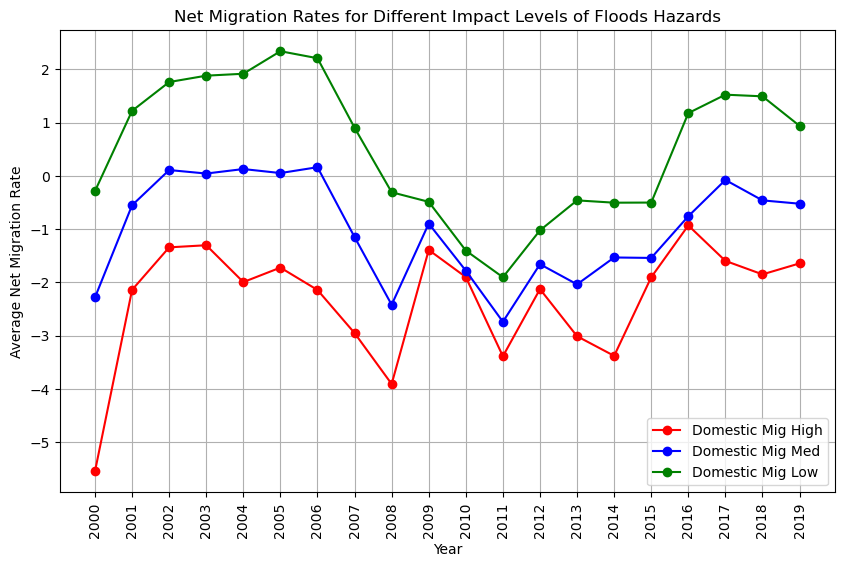

In [147]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
# plt.plot(years, yearly_flooding_all_domesmean.values, marker='o', linestyle='--', color='b', label='Domestic Mig All',alpha=0.4)
# plt.plot(years, yearly_flooding_all_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig All',alpha=0.4)
plt.plot(years, yearly_flooding_high_domesmean.values, marker='o', linestyle='-', color='r', label='Domestic Mig High')
# plt.plot(years, yearly_flooding_high_intermean.values, marker='o', linestyle='--', color='r', label='Inter Mig High')
plt.plot(years, yearly_flooding_med_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig Med')
# plt.plot(years, yearly_flooding_med_intermean.values, marker='o', linestyle='--', color='b', label='Inter Mig Med')
plt.plot(years, yearly_flooding_low_domesmean.values, marker='o', linestyle='-', color='g', label='Domestic Mig Low')
# plt.plot(years, yearly_flooding_low_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig Low')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Floods Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

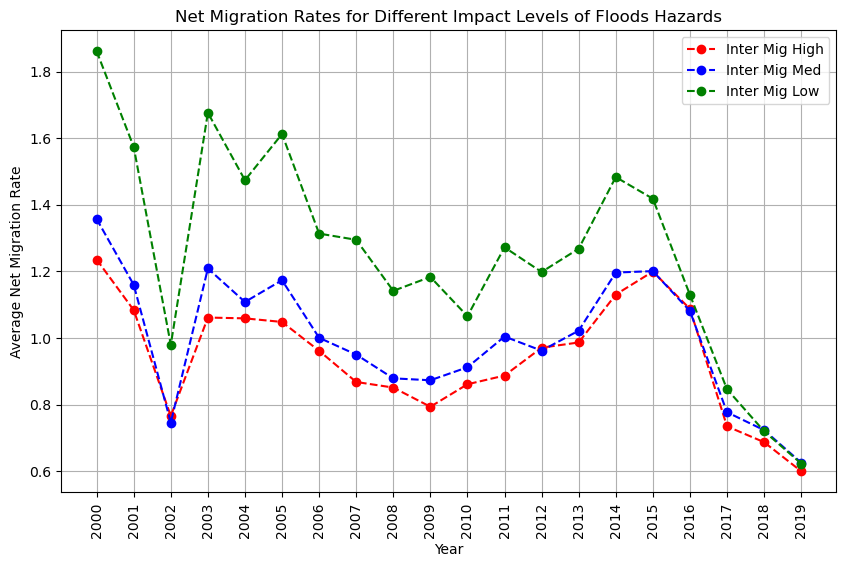

In [148]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
# plt.plot(years, yearly_flooding_all_domesmean.values, marker='o', linestyle='--', color='b', label='Domestic Mig All',alpha=0.4)
# plt.plot(years, yearly_flooding_all_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig All',alpha=0.4)
# plt.plot(years, yearly_flooding_high_domesmean.values, marker='o', linestyle='-', color='r', label='Domestic Mig High')
plt.plot(years, yearly_flooding_high_intermean.values, marker='o', linestyle='--', color='r', label='Inter Mig High')
# plt.plot(years, yearly_flooding_med_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig Med')
plt.plot(years, yearly_flooding_med_intermean.values, marker='o', linestyle='--', color='b', label='Inter Mig Med')
# plt.plot(years, yearly_flooding_low_domesmean.values, marker='o', linestyle='-', color='g', label='Domestic Mig Low')
plt.plot(years, yearly_flooding_low_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig Low')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Floods Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

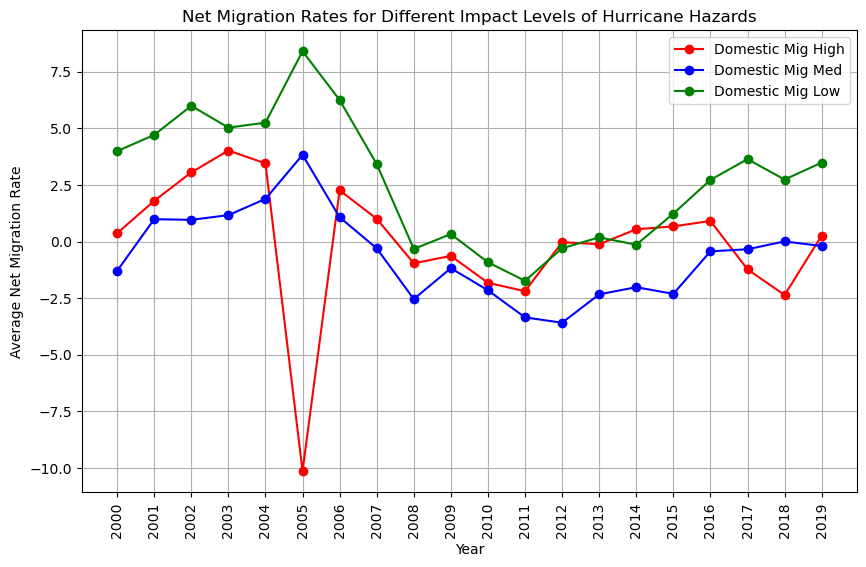

In [149]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
# plt.plot(years, yearly_flooding_all_domesmean.values, marker='o', linestyle='--', color='b', label='Domestic Mig All',alpha=0.4)
# plt.plot(years, yearly_flooding_all_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig All',alpha=0.4)
plt.plot(years, yearly_hurricane_high_domesmean.values, marker='o', linestyle='-', color='r', label='Domestic Mig High')
# plt.plot(years, yearly_hurricane_high_intermean.values, marker='o', linestyle='--', color='r', label='Inter Mig High')
plt.plot(years, yearly_hurricane_med_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig Med')
# plt.plot(years, yearly_hurricane_med_intermean.values, marker='o', linestyle='--', color='b', label='Inter Mig Med')
plt.plot(years, yearly_hurricane_low_domesmean.values, marker='o', linestyle='-', color='g', label='Domestic Mig Low')
# plt.plot(years, yearly_hurricane_low_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig Low')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Hurricane Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

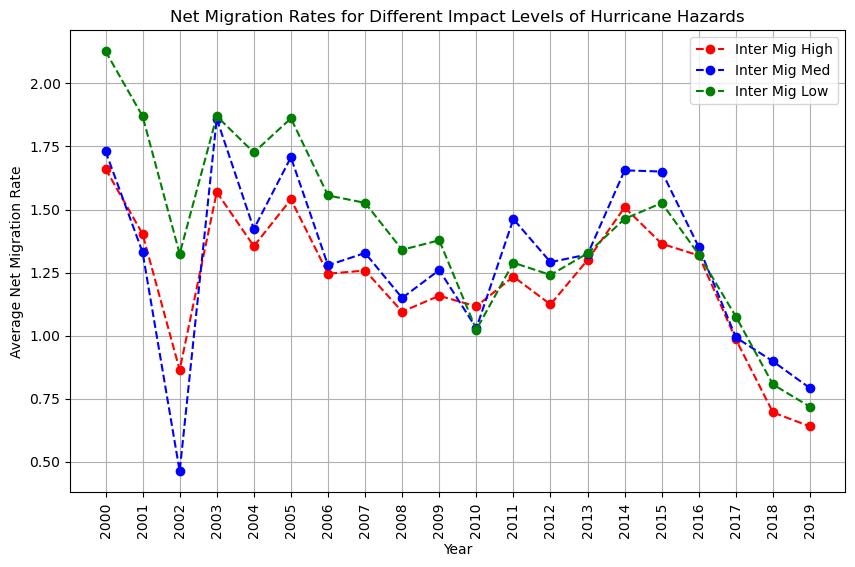

In [150]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
# plt.plot(years, yearly_flooding_all_domesmean.values, marker='o', linestyle='--', color='b', label='Domestic Mig All',alpha=0.4)
# plt.plot(years, yearly_flooding_all_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig All',alpha=0.4)
# plt.plot(years, yearly_hurricane_high_domesmean.values, marker='o', linestyle='-', color='r', label='Domestic Mig High')
plt.plot(years, yearly_hurricane_high_intermean.values, marker='o', linestyle='--', color='r', label='Inter Mig High')
# plt.plot(years, yearly_hurricane_med_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig Med')
plt.plot(years, yearly_hurricane_med_intermean.values, marker='o', linestyle='--', color='b', label='Inter Mig Med')
# plt.plot(years, yearly_hurricane_low_domesmean.values, marker='o', linestyle='-', color='g', label='Domestic Mig Low')
plt.plot(years, yearly_hurricane_low_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig Low')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Hurricane Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

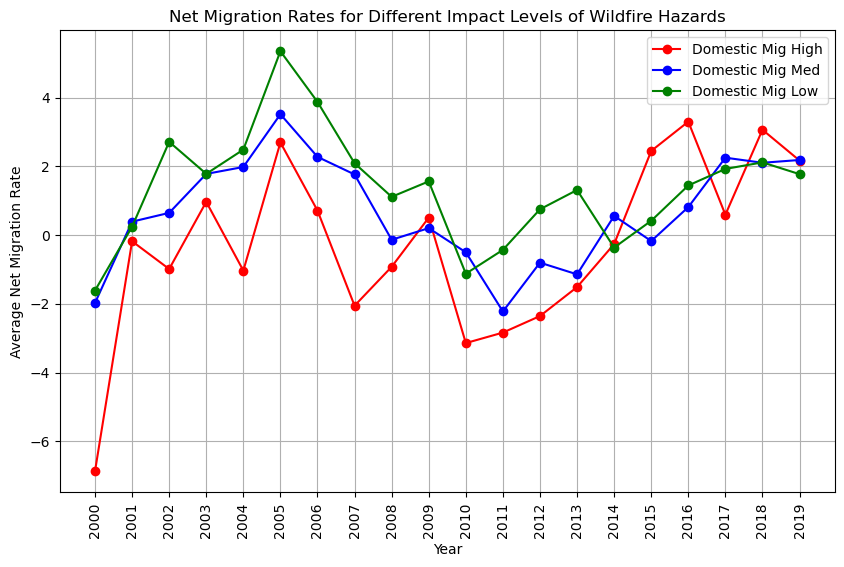

In [151]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
# plt.plot(years, yearly_flooding_all_domesmean.values, marker='o', linestyle='--', color='b', label='Domestic Mig All',alpha=0.4)
# plt.plot(years, yearly_flooding_all_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig All',alpha=0.4)
plt.plot(years, yearly_wildfire_high_domesmean.values, marker='o', linestyle='-', color='r', label='Domestic Mig High')
# plt.plot(years, yearly_wildfire_high_intermean.values, marker='o', linestyle='--', color='r', label='Inter Mig High')
plt.plot(years, yearly_wildfire_med_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig Med')
# plt.plot(years, yearly_wildfire_med_intermean.values, marker='o', linestyle='--', color='b', label='Inter Mig Med')
plt.plot(years, yearly_wildfire_low_domesmean.values, marker='o', linestyle='-', color='g', label='Domestic Mig Low')
# plt.plot(years, yearly_wildfire_low_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig Low')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Wildfire Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

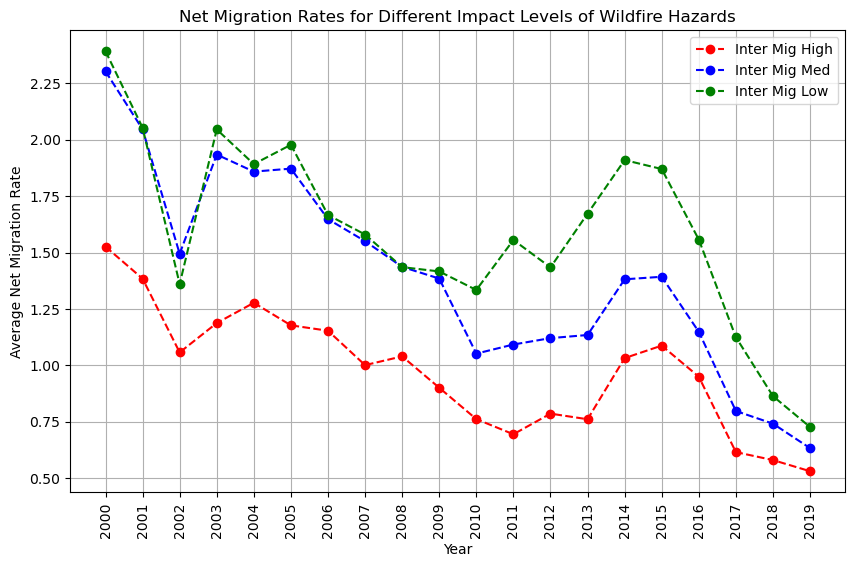

In [152]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
# plt.plot(years, yearly_flooding_all_domesmean.values, marker='o', linestyle='--', color='b', label='Domestic Mig All',alpha=0.4)
# plt.plot(years, yearly_flooding_all_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig All',alpha=0.4)
# plt.plot(years, yearly_wildfire_high_domesmean.values, marker='o', linestyle='-', color='r', label='Domestic Mig High')
plt.plot(years, yearly_wildfire_high_intermean.values, marker='o', linestyle='--', color='r', label='Inter Mig High')
# plt.plot(years, yearly_wildfire_med_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig Med')
plt.plot(years, yearly_wildfire_med_intermean.values, marker='o', linestyle='--', color='b', label='Inter Mig Med')
# plt.plot(years, yearly_wildfire_low_domesmean.values, marker='o', linestyle='-', color='g', label='Domestic Mig Low')
plt.plot(years, yearly_wildfire_low_intermean.values, marker='o', linestyle='--', color='g', label='Inter Mig Low')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Wildfire Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

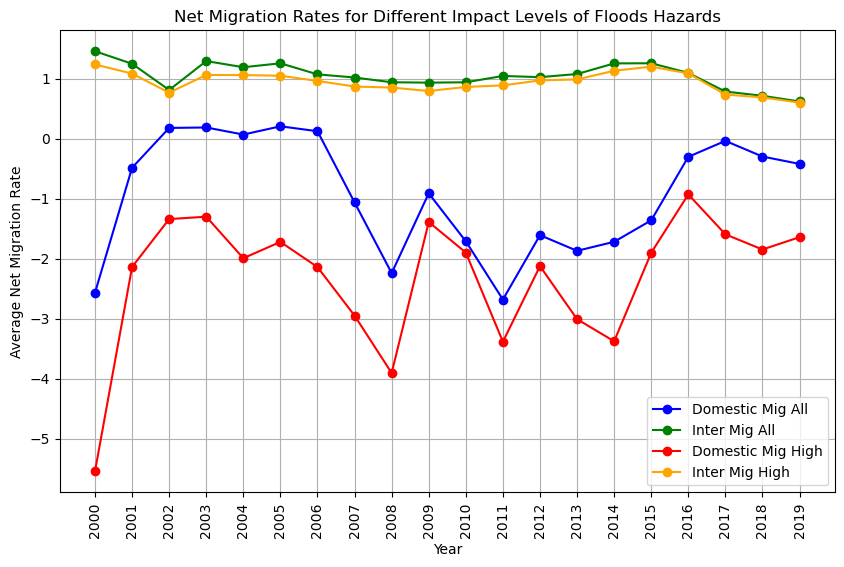

In [95]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
plt.plot(years, yearly_flooding_all_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig All')
plt.plot(years, yearly_flooding_all_intermean.values, marker='o', linestyle='-', color='g', label='Inter Mig All')
plt.plot(years, yearly_flooding_high_domesmean.values, marker='o', linestyle='-', color='red', label='Domestic Mig High')
plt.plot(years, yearly_flooding_high_intermean.values, marker='o', linestyle='-', color='orange', label='Inter Mig High')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Floods Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

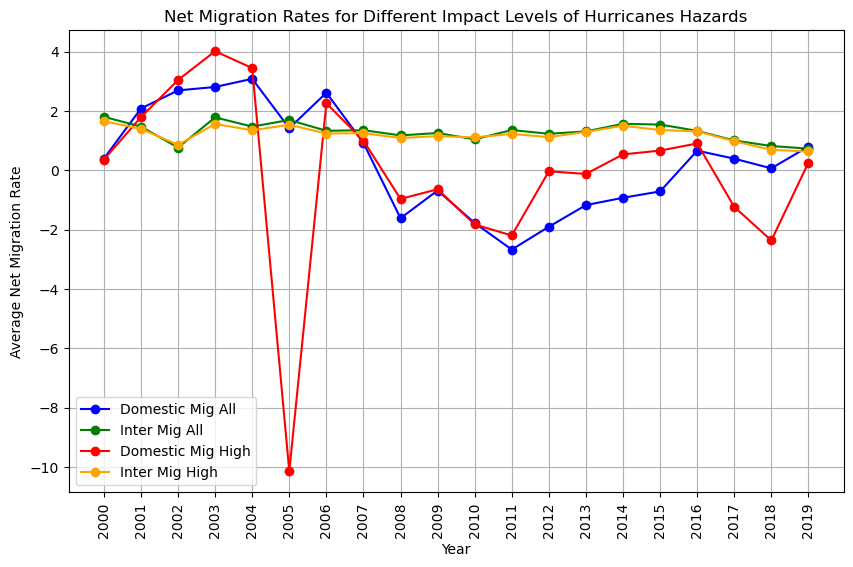

In [96]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
plt.plot(years, yearly_hurricane_all_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig All')
plt.plot(years, yearly_hurricane_all_intermean.values, marker='o', linestyle='-', color='g', label='Inter Mig All')
plt.plot(years, yearly_hurricane_high_domesmean.values, marker='o', linestyle='-', color='red', label='Domestic Mig High')
plt.plot(years, yearly_hurricane_high_intermean.values, marker='o', linestyle='-', color='orange', label='Inter Mig High')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Hurricanes Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

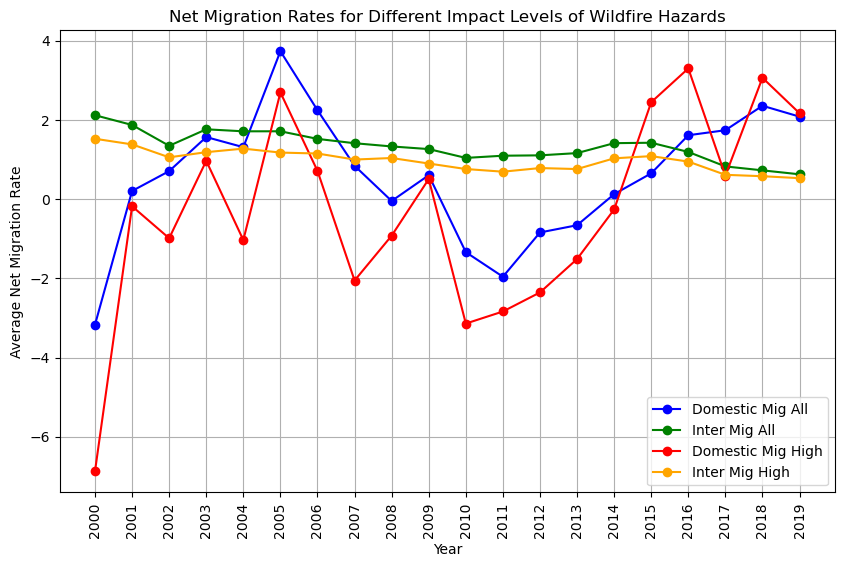

In [97]:
# Create a line chart with multiple lines
plt.figure(figsize=(10, 6))

years = list(range(2000, 2020))
# Plot each dataset
plt.plot(years, yearly_wildfire_all_domesmean.values, marker='o', linestyle='-', color='b', label='Domestic Mig All')
plt.plot(years, yearly_wildfire_all_intermean.values, marker='o', linestyle='-', color='g', label='Inter Mig All')
plt.plot(years, yearly_wildfire_high_domesmean.values, marker='o', linestyle='-', color='red', label='Domestic Mig High')
plt.plot(years, yearly_wildfire_high_intermean.values, marker='o', linestyle='-', color='orange', label='Inter Mig High')

# Add titles and labels
plt.title('Net Migration Rates for Different Impact Levels of Wildfire Hazards')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(years,rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [98]:
flooding_year = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Flooding"]
flooding_year = flooding_year[~((flooding_year['Year'] == 2000) & (flooding_year['Month'] <= 6))]
flooding_year = flooding_year[~((flooding_year['Year'] == 2020) & (flooding_year['Month'] >= 7))]

flooding_year['Period'] = flooding_year.apply(determine_period, axis=1)

In [99]:
# flooding_year = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Flooding"]
flooding_year = flooding_year.groupby(["Hazard","Period"]).agg({
    "Month":"count",
    "PropertyDmg(ADJ 2020)":"sum",                                                                     
    "PropertyDmgPerCapita(ADJ 2020)":"sum"
    
}).reset_index()
flooding_year = flooding_year.rename(columns={"Month":"count"})

In [100]:
hurricane_year = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Hurricane/Tropical Storm"]

hurricane_year = hurricane_year[~((hurricane_year['Year'] == 2000) & (hurricane_year['Month'] <= 6))]
hurricane_year = hurricane_year[~((hurricane_year['Year'] == 2020) & (hurricane_year['Month'] >= 7))]

hurricane_year['Period'] = hurricane_year.apply(determine_period, axis=1)

hurricane_year = hurricane_year.groupby(["Hazard","Period"]).agg({
    "Month":"count",
    "PropertyDmg(ADJ 2020)":"sum",                                                                     
    "PropertyDmgPerCapita(ADJ 2020)":"sum"
    
}).reset_index()
hurricane_year = hurricane_year.rename(columns={"Month":"count"})

In [101]:
wildfire_year = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Wildfire"]

wildfire_year = wildfire_year[~((wildfire_year['Year'] == 2000) & (wildfire_year['Month'] <= 6))]
wildfire_year = wildfire_year[~((wildfire_year['Year'] == 2020) & (wildfire_year['Month'] >= 7))]

wildfire_year['Period'] = wildfire_year.apply(determine_period, axis=1)

wildfire_year = wildfire_year.groupby(["Hazard","Period"]).agg({
    "Month":"count",
    "PropertyDmg(ADJ 2020)":"sum",                                                                     
    "PropertyDmgPerCapita(ADJ 2020)":"sum"
    
}).reset_index()
wildfire_year = wildfire_year.rename(columns={"Month":"count"})

In [102]:
columns = [
    'Net migration rate flooding domestic',
    'Net migration rate next flooding domestic',
    'Net migration rate flooding international',
    'Net migration rate next flooding international',
    'Total count of flooding',
    'Total property damage of flooding',
    'Property Damage per capita of flooding',
    'Net migration rate hurricane domestic',
    'Net migration rate next hurricane domestic',
    'Net migration rate hurricane international',
    'Net migration rate next hurricane international',
    'Total count of hurricane',
    'Total property damage of hurricane',
    'Property Damage per capita of hurricane',   
    'Net migration rate wildfire domestic',
    'Net migration rate next wildfire domestic',
    'Net migration rate wildfire international',
    'Net migration rate next wildfire international',
    'Total count of wildfire',
    'Total property damage of wildfire',
    'Property Damage per capita of wildfire',
]

years = range(2001, 2021)
all_cor = pd.DataFrame(columns=columns,index=years)
all_cor = all_cor.reset_index(drop=False)
all_cor = all_cor.rename(columns={"index":"Year"})

In [103]:
all_cor['Net migration rate flooding domestic'] = list(yearly_flooding_all_domesmean)
all_cor['Net migration rate next flooding domestic'][0:-1] = list(yearly_flooding_all_domesmean)[1:]
all_cor['Net migration rate flooding international'] = list(yearly_flooding_all_intermean)
all_cor['Net migration rate next flooding international'][0:-1] = list(yearly_flooding_all_intermean)[1:]
all_cor["Total count of flooding"]=flooding_year["count"]
all_cor["Total property damage of flooding"] = flooding_year["PropertyDmg(ADJ 2020)"]
all_cor["Property Damage per capita of flooding"] = flooding_year["PropertyDmgPerCapita(ADJ 2020)"]
all_cor['Net migration rate hurricane domestic'] = list(yearly_hurricane_all_domesmean)
all_cor['Net migration rate next hurricane domestic'][0:-1] = list(yearly_hurricane_all_domesmean)[1:]
all_cor['Net migration rate hurricane international'] = list(yearly_hurricane_all_intermean)
all_cor['Net migration rate next hurricane international'][0:-1] = list(yearly_hurricane_all_intermean)[1:]
all_cor["Total count of hurricane"]=hurricane_year["count"]
all_cor["Total property damage of hurricane"] = hurricane_year["PropertyDmg(ADJ 2020)"]
all_cor["Property Damage per capita of hurricane"] = hurricane_year["PropertyDmgPerCapita(ADJ 2020)"]
all_cor['Net migration rate wildfire domestic'] = list(yearly_wildfire_all_domesmean)
all_cor['Net migration rate next wildfire domestic'][0:-1] = list(yearly_wildfire_all_domesmean)[1:]
all_cor['Net migration rate wildfire international'] = list(yearly_wildfire_all_intermean)
all_cor['Net migration rate next wildfire international'][0:-1] = list(yearly_wildfire_all_intermean)[1:]
all_cor["Total count of wildfire"]=wildfire_year["count"]
all_cor["Total property damage of wildfire"] = wildfire_year["PropertyDmg(ADJ 2020)"]
all_cor["Property Damage per capita of wildfire"] = wildfire_year["PropertyDmgPerCapita(ADJ 2020)"]

C:\Users\xiang11\AppData\Local\Temp\ipykernel_33016\4041752978.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_cor['Net migration rate next flooding domestic'][0:-1] = list(yearly_flooding_all_domesmean)[1:]
C:\Users\xiang11\AppData\

In [104]:
variables = [
    'Total count of ',
    'Total property damage of ',
    'Property Damage per capita of '
]
hazards = ["flooding","hurricane","wildfire"]

results = []

for hazard in hazards:
    for var in variables:
        print(hazard,var)
        df_temp = all_cor[[f'Net migration rate {hazard} domestic',var+hazard]]
        df_temp = df_temp.dropna()
        df_temp_next = all_cor[[f'Net migration rate next {hazard} domestic',var+hazard]]
        df_temp_next = df_temp_next.dropna()        
        df_temp_next[f'Net migration rate next {hazard} domestic'] = pd.to_numeric(df_temp_next[f'Net migration rate next {hazard} domestic'], errors='coerce')
        df_temp_next[var+hazard] = pd.to_numeric(df_temp_next[var+hazard], errors='coerce')
        corr_coeff, p_value = pearsonr(df_temp[f'Net migration rate {hazard} domestic'], df_temp[var+hazard])
        corr_coeff_next_year, p_value_next_year = pearsonr(df_temp_next[f'Net migration rate next {hazard} domestic'], df_temp_next[var+hazard])
        results.append([corr_coeff, p_value, corr_coeff_next_year, p_value_next_year])

flooding Total count of 
flooding Total property damage of 
flooding Property Damage per capita of 
hurricane Total count of 
hurricane Total property damage of 
hurricane Property Damage per capita of 
wildfire Total count of 
wildfire Total property damage of 
wildfire Property Damage per capita of 


In [105]:
result_df = pd.DataFrame(results, columns=['Correlation with Net migration rate (domestic_all)', 'P-value',
                                           'Correlation with Net migration rate in next year (domestic_all)', 'P-value next year'],
                         index=["Total count of flooding","Total property damage of flooding","Property Damage per capita of flooding",
                               "Total count of hurricane/tropical storm","Total property damage of hurricane/tropical storm","Property Damage per capita of flooding/tropical storm",
                               "Total count of wildfire","Total property damage of wildfire","Property Damage per capita of wildfire"])

In [106]:
result_df

,Correlation with Net migration rate (domestic_all),P-value,Correlation with Net migration rate in next year (domestic_all),P-value next year
Total count of flooding,0.100754,0.672549,-0.393959,0.095130
Total property damage of flooding,0.151625,0.523386,-0.047089,0.848191
Property Damage per capita of flooding,0.180814,0.445535,-0.014142,0.954176
Total count of hurricane/tropical storm,0.068583,0.780259,0.252142,0.297692
Total property damage of hurricane/tropical storm,0.162053,0.507446,0.269190,0.265089
Property Damage per capita of flooding/tropical storm,0.177505,0.467224,0.316231,0.187171
Total count of wildfire,-0.204866,0.386250,-0.362667,0.127007
Total property damage of wildfire,0.245171,0.297482,0.190514,0.434654
Property Damage per capita of wildfire,0.274631,0.241274,0.098493,0.688308


In [107]:
variables = [
    'Total count of ',
    'Total property damage of ',
    'Property Damage per capita of '
]
hazards = ["flooding","hurricane","wildfire"]

results = []

for hazard in hazards:
    for var in variables:
        print(hazard,var)
        df_temp = all_cor[[f'Net migration rate {hazard} international',var+hazard]]
        df_temp = df_temp.dropna()
        df_temp_next = all_cor[[f'Net migration rate next {hazard} international',var+hazard]]
        df_temp_next = df_temp_next.dropna()        
        df_temp_next[f'Net migration rate next {hazard} international'] = pd.to_numeric(df_temp_next[f'Net migration rate next {hazard} international'], errors='coerce')
        df_temp_next[var+hazard] = pd.to_numeric(df_temp_next[var+hazard], errors='coerce')
        corr_coeff, p_value = pearsonr(df_temp[f'Net migration rate {hazard} international'], df_temp[var+hazard])
        corr_coeff_next_year, p_value_next_year = pearsonr(df_temp_next[f'Net migration rate next {hazard} international'], df_temp_next[var+hazard])
        results.append([corr_coeff, p_value, corr_coeff_next_year, p_value_next_year])

flooding Total count of 
flooding Total property damage of 
flooding Property Damage per capita of 
hurricane Total count of 
hurricane Total property damage of 
hurricane Property Damage per capita of 
wildfire Total count of 
wildfire Total property damage of 
wildfire Property Damage per capita of 


In [108]:
result_df = pd.DataFrame(results, columns=['Correlation with Net migration rate (international_all)', 'P-value',
                                           'Correlation with Net migration rate in next year (international_all)', 'P-value next year'],
                         index=["Total count of flooding","Total property damage of flooding","Property Damage per capita of flooding",
                               "Total count of hurricane/tropical storm","Total property damage of hurricane/tropical storm","Property Damage per capita of flooding/tropical storm",
                               "Total count of wildfire","Total property damage of wildfire","Property Damage per capita of wildfire"])

In [109]:
result_df

,Correlation with Net migration rate (international_all),P-value,Correlation with Net migration rate in next year (international_all),P-value next year
Total count of flooding,-0.059179,0.804266,-0.033010,0.893281
Total property damage of flooding,-0.270650,0.248439,-0.424176,0.070297
Property Damage per capita of flooding,-0.328296,0.157604,-0.494483,0.031383
Total count of hurricane/tropical storm,0.090419,0.712778,0.036749,0.881269
Total property damage of hurricane/tropical storm,0.256356,0.289416,-0.051199,0.835107
Property Damage per capita of flooding/tropical storm,0.269876,0.263827,-0.037703,0.878209
Total count of wildfire,-0.396056,0.083867,-0.374696,0.113970
Total property damage of wildfire,-0.353317,0.126483,-0.438650,0.060280
Property Damage per capita of wildfire,-0.271187,0.247465,-0.381287,0.107247


In [110]:
flooding_year_high = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Flooding"]
flooding_year_high = flooding_year_high[flooding_year_high["County FIPS"].isin(flooding_high_list)]
flooding_year_high = flooding_year_high[~((flooding_year_high['Year'] == 2000) & (flooding_year_high['Month'] <= 6))]
flooding_year_high = flooding_year_high[~((flooding_year_high['Year'] == 2020) & (flooding_year_high['Month'] >= 7))]

flooding_year_high['Period'] = flooding_year_high.apply(determine_period, axis=1)

flooding_year_high = flooding_year_high.groupby(["Hazard","Period"]).agg({
    "Month":"count",
    "PropertyDmg(ADJ 2020)":"sum",                                                                     
    "PropertyDmgPerCapita(ADJ 2020)":"sum"
    
}).reset_index()
flooding_year_high = flooding_year_high.rename(columns={"Month":"count"})

In [111]:
hurricane_year_high = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Hurricane/Tropical Storm"]
hurricane_year_high = hurricane_year_high[hurricane_year_high["County FIPS"].isin(hurricane_high_list)]
hurricane_year_high = hurricane_year_high[~((hurricane_year_high['Year'] == 2000) & (hurricane_year_high['Month'] <= 6))]
hurricane_year_high = hurricane_year_high[~((hurricane_year_high['Year'] == 2020) & (hurricane_year_high['Month'] >= 7))]

hurricane_year_high['Period'] = hurricane_year_high.apply(determine_period, axis=1)

hurricane_year_high = hurricane_year_high.groupby(["Hazard","Period"]).agg({
    "Month":"count",
    "PropertyDmg(ADJ 2020)":"sum",                                                                     
    "PropertyDmgPerCapita(ADJ 2020)":"sum"
    
}).reset_index()
hurricane_year_high = hurricane_year_high.rename(columns={"Month":"count"})

In [112]:
wildfire_year_high = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Wildfire"]
wildfire_year_high = wildfire_year_high[wildfire_year_high["County FIPS"].isin(wildfire_high_list)]
wildfire_year_high = wildfire_year_high[~((wildfire_year_high['Year'] == 2000) & (wildfire_year_high['Month'] <= 6))]
wildfire_year_high = wildfire_year_high[~((wildfire_year_high['Year'] == 2020) & (wildfire_year_high['Month'] >= 7))]

wildfire_year_high['Period'] = wildfire_year_high.apply(determine_period, axis=1)

wildfire_year_high = wildfire_year_high.groupby(["Hazard","Period"]).agg({
    "Month":"count",
    "PropertyDmg(ADJ 2020)":"sum",                                                                     
    "PropertyDmgPerCapita(ADJ 2020)":"sum"
    
}).reset_index()
wildfire_year_high = wildfire_year_high.rename(columns={"Month":"count"})

In [113]:
columns = [
    'Net migration rate flooding domestic',
    'Net migration rate next flooding domestic',
    'Net migration rate flooding international',
    'Net migration rate next flooding international',
    'Total count of flooding',
    'Total property damage of flooding',
    'Property Damage per capita of flooding',
    'Net migration rate hurricane domestic',
    'Net migration rate next hurricane domestic',
    'Net migration rate hurricane international',
    'Net migration rate next hurricane international',
    'Total count of hurricane',
    'Total property damage of hurricane',
    'Property Damage per capita of hurricane',   
    'Net migration rate wildfire domestic',
    'Net migration rate next wildfire domestic',
    'Net migration rate wildfire international',
    'Net migration rate next wildfire international',
    'Total count of wildfire',
    'Total property damage of wildfire',
    'Property Damage per capita of wildfire',
]

years = range(2001, 2021)
high_cor = pd.DataFrame(columns=columns,index=years)
high_cor = high_cor.reset_index(drop=False)
high_cor = high_cor.rename(columns={"index":"Year"})

In [114]:
high_cor['Net migration rate flooding domestic'] = list(yearly_flooding_high_domesmean)
high_cor['Net migration rate next flooding domestic'][0:-1] = list(yearly_flooding_high_domesmean)[1:]
high_cor['Net migration rate flooding international'] = list(yearly_flooding_high_intermean)
high_cor['Net migration rate next flooding international'][0:-1] = list(yearly_flooding_high_intermean)[1:]
high_cor["Total count of flooding"]=flooding_year_high["count"]
high_cor["Total property damage of flooding"] = flooding_year_high["PropertyDmg(ADJ 2020)"]
high_cor["Property Damage per capita of flooding"] = flooding_year_high["PropertyDmgPerCapita(ADJ 2020)"]
high_cor['Net migration rate hurricane domestic'] = list(yearly_hurricane_high_domesmean)
high_cor['Net migration rate next hurricane domestic'][0:-1] = list(yearly_hurricane_high_domesmean)[1:]
high_cor['Net migration rate hurricane international'] = list(yearly_hurricane_high_intermean)
high_cor['Net migration rate next hurricane international'][0:-1] = list(yearly_hurricane_high_intermean)[1:]
high_cor["Total count of hurricane"]=hurricane_year_high["count"]
high_cor["Total property damage of hurricane"] = hurricane_year_high["PropertyDmg(ADJ 2020)"]
high_cor["Property Damage per capita of hurricane"] = hurricane_year_high["PropertyDmgPerCapita(ADJ 2020)"]
high_cor['Net migration rate wildfire domestic'] = list(yearly_wildfire_high_domesmean)
high_cor['Net migration rate next wildfire domestic'][0:-1] = list(yearly_wildfire_high_domesmean)[1:]
high_cor['Net migration rate wildfire international'] = list(yearly_wildfire_high_intermean)
high_cor['Net migration rate next wildfire international'][0:-1] = list(yearly_wildfire_high_intermean)[1:]
high_cor["Total count of wildfire"]=wildfire_year_high["count"]
high_cor["Total property damage of wildfire"] = wildfire_year_high["PropertyDmg(ADJ 2020)"]
high_cor["Property Damage per capita of wildfire"] = wildfire_year_high["PropertyDmgPerCapita(ADJ 2020)"]

C:\Users\xiang11\AppData\Local\Temp\ipykernel_33016\3152651654.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  high_cor['Net migration rate next flooding domestic'][0:-1] = list(yearly_flooding_high_domesmean)[1:]
C:\Users\xiang11\AppDat

In [115]:
variables = [
    'Total count of ',
    'Total property damage of ',
    'Property Damage per capita of '
]
hazards = ["flooding","hurricane","wildfire"]

results = []

for hazard in hazards:
    for var in variables:
        print(hazard,var)
        df_temp = high_cor[[f'Net migration rate {hazard} domestic',var+hazard]]
        df_temp = df_temp.dropna()
        df_temp_next = high_cor[[f'Net migration rate next {hazard} domestic',var+hazard]]
        df_temp_next = df_temp_next.dropna()        
        df_temp_next[f'Net migration rate next {hazard} domestic'] = pd.to_numeric(df_temp_next[f'Net migration rate next {hazard} domestic'], errors='coerce')
        df_temp_next[var+hazard] = pd.to_numeric(df_temp_next[var+hazard], errors='coerce')
        corr_coeff, p_value = pearsonr(df_temp[f'Net migration rate {hazard} domestic'], df_temp[var+hazard])
        corr_coeff_next_year, p_value_next_year = pearsonr(df_temp_next[f'Net migration rate next {hazard} domestic'], df_temp_next[var+hazard])
        results.append([corr_coeff, p_value, corr_coeff_next_year, p_value_next_year])

flooding Total count of 
flooding Total property damage of 
flooding Property Damage per capita of 
hurricane Total count of 
hurricane Total property damage of 
hurricane Property Damage per capita of 
wildfire Total count of 
wildfire Total property damage of 
wildfire Property Damage per capita of 


In [116]:
result_df = pd.DataFrame(results, columns=['Correlation with Net migration rate (domestic_high)', 'P-value',
                                           'Correlation with Net migration rate in next year (domestic_high)', 'P-value next year'],
                         index=["Total count of flooding","Total property damage of flooding","Property Damage per capita of flooding",
                               "Total count of hurricane/tropical storm","Total property damage of hurricane/tropical storm","Property Damage per capita of flooding/tropical storm",
                               "Total count of wildfire","Total property damage of wildfire","Property Damage per capita of wildfire"])

In [117]:
result_df

,Correlation with Net migration rate (domestic_high),P-value,Correlation with Net migration rate in next year (domestic_high),P-value next year
Total count of flooding,0.344732,0.136621,-0.398801,0.090774
Total property damage of flooding,0.291262,0.212793,-0.058615,0.811606
Property Damage per capita of flooding,0.218697,0.354263,-0.023333,0.924463
Total count of hurricane/tropical storm,-0.496473,0.030603,-0.034234,0.889346
Total property damage of hurricane/tropical storm,-0.573550,0.010244,-0.037039,0.880338
Property Damage per capita of flooding/tropical storm,-0.764484,0.000138,0.094691,0.699797
Total count of wildfire,-0.234093,0.334741,-0.376601,0.111997
Total property damage of wildfire,0.078379,0.749769,0.316005,0.187503
Property Damage per capita of wildfire,0.228587,0.346558,0.270797,0.262136


In [118]:
variables = [
    'Total count of ',
    'Total property damage of ',
    'Property Damage per capita of '
]
hazards = ["flooding","hurricane","wildfire"]

results = []

for hazard in hazards:
    for var in variables:
        print(hazard,var)
        df_temp = high_cor[[f'Net migration rate {hazard} international',var+hazard]]
        df_temp = df_temp.dropna()
        df_temp_next = high_cor[[f'Net migration rate next {hazard} international',var+hazard]]
        df_temp_next = df_temp_next.dropna()        
        df_temp_next[f'Net migration rate next {hazard} international'] = pd.to_numeric(df_temp_next[f'Net migration rate next {hazard} international'], errors='coerce')
        df_temp_next[var+hazard] = pd.to_numeric(df_temp_next[var+hazard], errors='coerce')
        corr_coeff, p_value = pearsonr(df_temp[f'Net migration rate {hazard} international'], df_temp[var+hazard])
        corr_coeff_next_year, p_value_next_year = pearsonr(df_temp_next[f'Net migration rate next {hazard} international'], df_temp_next[var+hazard])
        results.append([corr_coeff, p_value, corr_coeff_next_year, p_value_next_year])

flooding Total count of 
flooding Total property damage of 
flooding Property Damage per capita of 
hurricane Total count of 
hurricane Total property damage of 
hurricane Property Damage per capita of 
wildfire Total count of 
wildfire Total property damage of 
wildfire Property Damage per capita of 


In [119]:
result_df = pd.DataFrame(results, columns=['Correlation with Net migration rate (international_high)', 'P-value',
                                           'Correlation with Net migration rate in next year (international_high)', 'P-value next year'],
                         index=["Total count of flooding","Total property damage of flooding","Property Damage per capita of flooding",
                               "Total count of hurricane/tropical storm","Total property damage of hurricane/tropical storm","Property Damage per capita of flooding/tropical storm",
                               "Total count of wildfire","Total property damage of wildfire","Property Damage per capita of wildfire"])

In [120]:
result_df

,Correlation with Net migration rate (international_high),P-value,Correlation with Net migration rate in next year (international_high),P-value next year
Total count of flooding,-0.257275,0.273496,-0.351755,0.139715
Total property damage of flooding,-0.182138,0.442154,-0.382341,0.106199
Property Damage per capita of flooding,-0.302460,0.194921,-0.475004,0.039862
Total count of hurricane/tropical storm,0.022169,0.928220,0.141770,0.562625
Total property damage of hurricane/tropical storm,0.273427,0.257348,-0.045923,0.851912
Property Damage per capita of flooding/tropical storm,0.266137,0.270756,-0.050010,0.838887
Total count of wildfire,-0.514262,0.024283,-0.521125,0.022139
Total property damage of wildfire,-0.394679,0.094473,-0.391226,0.097655
Property Damage per capita of wildfire,-0.233587,0.335817,-0.212087,0.383382
